# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. Complete the required functions in `hw4.py` script only. This exercise is graded automatically, and only the `hw4.py` script is tested.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/), numpy and pandas only. **Do not import anything else.**
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes this notebook with the exercise number and your ID as the filename and the `hw4.py` script. For example: `hw4_123456789_987654321.ipynb` and `hw4.py` if you submitted in pairs and `hw4_123456789.ipynb` and `hw4.py` if you submitted the exercise alone.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#hw4.py

from scipy.stats import multivariate_normal as mvn


def pearson_correlation( x, y):
    """
    Calculate the Pearson correlation coefficient for two given columns of data.

    Inputs:
    - x: An array containing a column of m numeric values.
    - y: An array containing a column of m numeric values. 

    Returns:
    - The Pearson correlation coefficient between the two columns.    
    """
    r = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sqrt(np.sum((x - mean_x)**2) * np.sum((y - mean_y)**2))
    r = numerator / denominator if denominator != 0 else 0
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return r

def feature_selection(X, y, n_features=5):
    """
    Select the best features using pearson correlation.

    Input:
    - X: Input data (m instances over n features).
    - y: True labels (m instances).

    Returns:
    - best_features: list of best features (names - list of strings).  
    """
    best_features = []
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.dropna(axis=1, how='any')
    
    correlations = []
    for i in range(X.shape[1]):
        if isinstance(X, pd.DataFrame):
            x_i = X.iloc[:, i]
        else:  # Assume it's a NumPy array
            x_i = X[:, i]
            
        correlation = pearson_correlation(x_i, y)
        correlations.append((i, correlation))
    
    # Sort features by their absolute correlation values in descending order
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Select the top n features
    best_feature_indices = [index for index, _ in correlations[:n_features]]
    
    # Return feature names if X is a DataFrame, otherwise return indices
    if isinstance(X, pd.DataFrame):
        best_features = X.columns[best_feature_indices].tolist()
    else:
        best_features = best_feature_indices
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return best_features

class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """

    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

        # model parameters
        self.theta = None

        # iterations history
        self.Js = []
        self.thetas = []

    def fit(self, X, y):
        """
        Fit training data (the learning phase).
        Update the theta vector in each iteration using gradient descent.
        Store the theta vector in self.thetas.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        The learned parameters must be saved in self.theta.
        This function has no return value.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        # set random seed
        np.random.seed(self.random_state)

        ###########################################################################
        # TODO: Implement the function.                                           #
        ###########################################################################
        X = np.column_stack((np.ones(X.shape[0]), X)) # add bias column to X_array
        self.m = X.shape[0] # m instances
        self.theta = np.random.random(X.shape[1])
        self.J_history = []

        loss_chg = float('inf')
        iters = 1
    
        while loss_chg >= self.eps and iters <= self.n_iter: # stop at chg < eps or n_iter
            self.J_history.append(self.compute_cost(X, y, self.theta))   
            h = self.sigmoid(X @ self.theta)
            self.theta -= (self.eta / self.m) * X.T @ (h - y) # choosing mean(ie /m) vs sum method

            if iters > 1: 
                loss_chg = abs(self.J_history[iters - 1] - self.J_history[iters - 2]) # account for diff indexes

            iters += 1 
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def predict(self, X):
        """
        Return the predicted class labels for a given instance.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
        """
        preds = None
        ###########################################################################
        # TODO: Implement the function.                                           #
        ###########################################################################
        X = np.column_stack((np.ones(X.shape[0]), X)) # add bias column to X_array
        preds = np.round(self.sigmoid(X @ self.theta)) # >0.5: class 1, <0.5: class 0
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return preds
            
    def sigmoid(self, theta_x):
        sig_exp = np.exp(theta_x)
        return sig_exp / (1 + sig_exp)
    
    def compute_cost(self, X, y, theta):
        h = self.sigmoid(X @ theta)
    #         J = np.mean(((-y) @ np.log(h)) - ((1 - y) @ np.log(1 - h)))
        J = (1 / self.m) * (((-y) @ np.log(h)) - ((1 - y) @ np.log(1 - h))) # chg from np.mean saved immense time

        return J

def cross_validation(X, y, folds, algo, random_state):
    """
    This function performs cross validation as seen in class.

    1. shuffle the data and creates folds
    2. train the model on each fold
    3. calculate aggregated metrics

    Parameters
    ----------
    X : {array-like}, shape = [n_examples, n_features]
      Training vectors, where n_examples is the number of examples and
      n_features is the number of features.
    y : array-like, shape = [n_examples]
      Target values.
    folds : number of folds (int)
    algo : an object of the classification algorithm
    random_state : int
      Random number generator seed for random weight
      initialization.

    Returns the cross validation accuracy.
    """

    cv_accuracy = None

    # set random seed
    np.random.seed(random_state)

    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    fold_size = X.shape[0] // folds

    # Ensure X_train is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # Add y_train as a column to the DataFrame
    training_set_shuffled = X.copy()
    training_set_shuffled['y'] = y
    
    # Shuffle the training set before split
    training_set_shuffled = training_set_shuffled.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    accuracy_list = []

    for i in range(folds):
        start_index = i * fold_size
        stop_index = start_index + fold_size

        validation_set = training_set_shuffled[start_index:stop_index]
        train_set = training_set_shuffled.drop(validation_set.index)

        # Define training and validation sets
        X_train_folds = train_set.drop('y', axis=1)
        y_train_folds = train_set['y']
        X_validation = validation_set.drop('y', axis=1)
        y_validation = validation_set['y']

        # Train the classifier
        algo.fit(X_train_folds.values, y_train_folds.values)

        # Predict the labels for the validation set
        y_pred = algo.predict(X_validation.values)

        # Calculate accuracy
        accuracy = np.mean(y_pred == y_validation.values)
        accuracy_list.append(accuracy)
    
    
    cv_accuracy = sum(accuracy_list) / len(accuracy_list)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return cv_accuracy

def norm_pdf(data, mu, sigma):
    """
    Calculate normal desnity function for a given data,
    mean and standrad deviation.
 
    Input:
    - x: A value we want to compute the distribution for.
    - mu: The mean value of the distribution.
    - sigma:  The standard deviation of the distribution.
 
    Returns the normal distribution pdf according to the given mu and sigma for the given x.    
    """
    p = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    return 1 / (sigma * ((2 * np.pi) ** 0.5)) * np.exp(-0.5 * (((data - mu) / sigma) ** 2)) 
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return p

class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1991):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

        np.random.seed(self.random_state)

        self.responsibilities = None
        self.weights = None
        self.mus = None
        self.sigmas = None
        self.costs = None

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        ###########################################################################
        # TODO: Implement the function.                                           #
        ###########################################################################
        # For init_params, choose to split data and take mean/std of each chunk as starting estimates
        chunks = data.shape[0] // self.k
        self.weights = np.array([1 / self.k] * self.k)
        self.mus = np.array([data[dist * chunks : (dist + 1) * chunks].mean() for dist in range(self.k)])
        self.sigmas = np.array([data[dist * chunks : (dist + 1) * chunks].std() for dist in range(self.k)])
   
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def expectation(self, data):
        """
        E step - This function should calculate and update the responsibilities
        """
        ###########################################################################
        # TODO: Implement the function.                                           #
        ###########################################################################
        # Create array of GMM likelihoods, according to: pdf_GMM = pdf_G1 * w1 + pdf_G2 * w2
        likelihoods = np.array([norm_pdf(data, self.mus[dist], self.sigmas[dist]) * self.weights[dist] for dist in range(self.k)])
        
        # Create responsibility array dividing likelihoods by sum of likelihoods across instances/rows
        self.responsibilities = likelihoods / np.sum(likelihoods, axis=0)


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def maximization(self, data):
        """
        M step - This function should calculate and update the distribution params
        """
        ###########################################################################
        # TODO: Implement the function.                                           #
        ###########################################################################
        self.weights = np.mean(self.responsibilities, axis=1)
        self.mus = np.array([np.mean(self.responsibilities[dist] * data) / self.weights[dist] for dist in range(self.k)])
        self.sigmas = np.array([np.sqrt(np.mean(self.responsibilities[dist] * ((data - self.mus[dist]) ** 2)) / self.weights[dist]) for dist                       in range(self.k)])
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def fit(self, data):
        """
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params
        for the distribution.
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        ###########################################################################
        # TODO: Implement the function.                                           #
        ###########################################################################
        self.init_params(data)

        # Initialize costs as an empty list
        self.costs = []
        
        prev_cost = 0
        cost_delta = float('inf')
        iters = 1

        while cost_delta >= self.eps and iters <= self.n_iter:
            # Calculate responsibilities
            self.expectation(data)

            # Update the current distribution params
            self.maximization(data)

            # Calculate cost of params
            likelihoods = np.array([norm_pdf(data, self.mus[dist], self.sigmas[dist]) * self.weights[dist] for dist in range(self.k)])
            cost = np.sum(-np.log2(np.sum(likelihoods, axis=0)))  # A sum of sums (1 sum > 1 Gauss, sum(sums) > GMM)
            self.costs.append(cost)
            cost_delta = abs(cost - prev_cost)

            prev_cost = cost
            iters += 1
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def get_dist_params(self):
        return self.weights, self.mus, self.sigmas

def gmm_pdf(data, weights, mus, sigmas):
    """
    Calculate gmm desnity function for a given data,
    mean and standrad deviation.
 
    Input:
    - data: A value we want to compute the distribution for.
    - weights: The weights for the GMM
    - mus: The mean values of the GMM.
    - sigmas:  The standard deviation of the GMM.
 
    Returns the GMM distribution pdf according to the given mus, sigmas and weights
    for the given data.    
    """
    pdf = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    pdf = np.zeros_like(data, dtype=float)
    for w, mu, sigma in zip(weights, mus, sigmas):
        pdf += w * norm_pdf(data, mu, sigma)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return pdf

class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gaussian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1, random_state=1991):
        self.k = k
        self.random_state = random_state
        self.prior = None

    def fit(self, X, y):
        """
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        ###########################################################################
        # TODO: Implement the function.                                           #
        ###########################################################################
        self.labels = np.unique(y).astype(int)
        self.features_num = X.shape[1]
        self.prior = {label: np.mean(y == label) for label in self.labels}
        self.dists = {label: {} for label in self.labels}
        
        for label in self.labels:
            filter_data_by_label = X[y == label]
            for feature_num in range(self.features_num):
                gmm = EM(k=self.k, random_state=self.random_state)
                gmm.fit(filter_data_by_label[:, feature_num])
                self.dists[label][feature_num] = gmm.get_dist_params()
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def predict(self, X):
        """
        Return the predicted class labels for a given instance.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
        """
        preds = None
        ###########################################################################
        # TODO: Implement the function.                                           #
        ###########################################################################
        posteriors = np.zeros((X.shape[0], len(self.labels)))

        for label in self.labels:
            prior_log_prob = np.log(self.prior[label])
            posteriors[:, label] = prior_log_prob

            for feature in range(self.features_num):
                weights, mus, sigmas = self.dists[label][feature]
                feature_likelihood = gmm_pdf(X[:, feature], weights, mus, sigmas)
                posteriors[:, label] += np.log(feature_likelihood)

        preds = posteriors.argmax(axis=1)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return preds

def plot_decision_regions(X, y, classifier, resolution=0.01, title=""):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.title(title)
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.show()
    
def create_Cost_plot(classifier_name, model):
    plt.figure(figsize=(8,6))
    plt.plot(model.J_history, color='r', linewidth=2.5)
    plt.title(f'Cost vs. Iterations - {classifier_name} Model', fontsize=16, y=1.02)
    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel('Cost (J_history)', fontsize=12)
    plt.grid()
    plt.show();
    
def model_evaluation(x_train, y_train, x_test, y_test, k, best_eta, best_eps):
    ''' 
    Read the full description of this function in the notebook.

    You should use visualization for self debugging using the provided
    visualization functions in the notebook.
    Make sure you return the accuracies according to the return dict.

    Parameters
    ----------
    x_train : array-like, shape = [n_train_examples, n_features]
      Training vectors, where n_examples is the number of examples and
      n_features is the number of features.
    y_train : array-like, shape = [n_train_examples]
      Target values.
    x_test : array-like, shape = [n_test_examples, n_features]
      Training vectors, where n_examples is the number of examples and
      n_features is the number of features.
    y_test : array-like, shape = [n_test_examples]
      Target values.
    k : Number of gaussians in each dimension
    best_eta : best eta from cv
    best_eps : best eta from cv
    ''' 

    lor_train_acc = None
    lor_test_acc = None
    bayes_train_acc = None
    bayes_test_acc = None

    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    # Logistic Regression:
    model_lr = LogisticRegressionGD(eta=best_eta, eps=best_eps)
    model_lr.fit(x_train, y_train)
    prediction_lr_train = model_lr.predict(x_train)
    prediction_lr_test = model_lr.predict(x_test)
    lor_train_acc = np.mean(prediction_lr_train == y_train)
    lor_test_acc = np.mean(prediction_lr_test == y_test)
    plt.xlabel('feature_x1', fontsize=12)
    plt.ylabel('feature_x2', fontsize=12)     
    plot_decision_regions(x_train, y_train, model_lr, title='Logistic Regression Model Decision Boundary')
    create_Cost_plot('Logistic Regression', model_lr)

    
    # Naive Bayes:
    model_nb = NaiveBayesGaussian(k=k, random_state=1991)
    model_nb.fit(x_train, y_train)
    prediction_nb_train = model_nb.predict(x_train)
    prediction_nb_test = model_nb.predict(x_test)
    bayes_train_acc = np.mean(prediction_nb_train == y_train)
    bayes_test_acc = np.mean(prediction_nb_test == y_test)
    plot_decision_regions(x_train, y_train, model_nb, title='Naive Bayes Model Decision Boundary')

    
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return {'lor_train_acc': lor_train_acc,
            'lor_test_acc': lor_test_acc,
            'bayes_train_acc': bayes_train_acc}

def generate_mvn_samples(d, mean, samples):
    return mvn.rvs(mean=np.full(d, mean), cov=np.eye(d), size=samples, random_state=42)

def calc_accuracies(train_nb, test_nb, lr_train, lr_test, nb_train, nb_test):
    accuracy_nb_better_lr_train = np.mean(lr_train == train_nb[:, -1])
    accuracy_nb_better_lr_test = np.mean(lr_test == test_nb[:, -1])
    accuracy_nb_better_nb_train = np.mean(nb_train == train_nb[:, -1])
    accuracy_nb_better_nb_test = np.mean(nb_test == test_nb[:, -1])
    print('Naive Bayes > LogisticRegression Model Accuracies: \n', '='*40, '\n')
    print(f'LoR Accuracies: Training = {accuracy_nb_better_lr_train:.2%}\nLoR_Test = {accuracy_nb_better_lr_test:.2%}\n')
    print(f'Naive Bayes Accuracies: Training = {accuracy_nb_better_nb_train:.2%}\nNB_Test = {accuracy_nb_better_nb_test:.2%}')    

def predict_class_LOR_NB(train_nb, test_nb, nb_classifier, lor_classifier):    
    lr_train = lor_classifier.predict(train_nb[:, :-1])
    lr_test = lor_classifier.predict(test_nb[:, :-1])
    nb_train = nb_classifier.predict(train_nb[:, :-1])
    nb_test = nb_classifier.predict(test_nb[:, :-1])
    calc_accuracies(train_nb, test_nb, lr_train, lr_test, nb_train, nb_test)

def create_dataset_a():
    means = [1, 9, 25]
    G = {}
    G_test = {}
    d = 3 # number of features or 'dimensions'
    m_tr, m_tst = 2000, 400 # m = # of samples in training (tr) and test (tst) sets
    for dist in range(3):
        G[dist] = generate_mvn_samples(d, means[dist], m_tr)
        G_test[dist] = generate_mvn_samples(d, means[dist], m_tst)

    train_nb = np.concatenate((np.c_[G[0], np.zeros(m_tr)], np.c_[G[1], np.ones(m_tr)], np.c_[G[2], np.zeros(m_tr)]))       
    test_nb = np.concatenate((np.c_[G_test[0], np.zeros(m_tst)], np.c_[G_test[1], np.ones(m_tst)], 
                              np.c_[G_test[2], np.zeros(m_tst)]))    
    return train_nb, test_nb, G

def create_dataset_b():
    means1 = [[0,5,10],[0,5,8]]
    cov1 = np.array([[1,0.95,0.9],[0.95,1,0.8],[0.9,0.8,1]])
    G1 = {}
    G1_test = {}
    d = 3 # number of features or 'dimensions'
    m_tr, m_tst = 2000, 400 # m = # of samples in training (tr) and test (tst) sets
    for dist in range(2):
        G1[dist] = mvn.rvs(mean=means1[dist], cov=cov1, size=m_tr) 
        G1_test[dist] = mvn.rvs(mean=means1[dist], cov=cov1, size=m_tst)
    train_lr = np.concatenate((np.c_[G1[0], np.zeros(m_tr)], np.c_[G1[1], np.ones(m_tr)]))
    test_lr = np.concatenate((np.c_[G1_test[0], np.zeros(m_tst)], np.c_[G1_test[1], np.ones(m_tst)]))    

    return train_lr, test_lr, G1

def visualizations_3D_A(G):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.scatter(G[0][:,0], G[0][:,1], G[0][:,2], color='k')
    ax.scatter(G[1][:,0], G[1][:,1], G[1][:,2], color='r')
    ax.scatter(G[2][:,0], G[2][:,1], G[2][:,2], color='k')
    ax.set_title('3D Plot of 3-feature Multivariate_Gaussians: Naive Bayes Outperforms', fontsize=16, y=1.02)
    ax.set_xlabel('x1', fontsize=14), ax.set_ylabel('x2', fontsize=14), ax.set_zlabel('x3', fontsize=14)
    plt.legend(labels=('Class_0', 'Class_1'), fontsize=14, markerscale=2, bbox_to_anchor=(0.5, 0.4, 0.3, 0))
    plt.show()

def visualizations_3D_B(G):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.scatter(G[0][:,0], G[0][:,1], G[0][:,2], color='k')
    ax.scatter(G[1][:,0], G[1][:,1], G[1][:,2], color='r')
    ax.set_title('3D Plot of 3-feature Multivariate_Gaussians: Logistic Regression Outperforms', fontsize=16, y=1.02)
    ax.set_xlabel('x1', fontsize=14), ax.set_ylabel('x2', fontsize=14), ax.set_zlabel('x3', fontsize=14)
    plt.legend(labels=('Class_0', 'Class_1'), fontsize=14, markerscale=2, bbox_to_anchor=(0.5, 0.4, 0.3, 0))
    plt.show()
            
def generate_datasets():
    from scipy.stats import multivariate_normal
    '''
    This function should have no input.
    It should generate the two dataset as described in the jupyter notebook,
    and return them according to the provided return dict.
    '''
    dataset_a_features = None
    dataset_a_labels = None
    dataset_b_features = None
    dataset_b_labels = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    train_a, test_a, G_a = create_dataset_a()
    train_b, test_b, G_b = create_dataset_b()

    # For dataset_a and dataset_b, the labels are the last column
    dataset_a_features = train_a[:, :-1]
    dataset_a_labels = train_a[:, -1]
    dataset_b_features = train_b[:, :-1]
    dataset_b_labels = train_b[:, -1]

    fig_a = visualizations_3D_A(G_a)
    fig_b = visualizations_3D_B(G_b)      
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
  
    return {
        'dataset_a_features': dataset_a_features,
        'dataset_a_labels': dataset_a_labels,
        'dataset_b_features': dataset_b_features,
        'dataset_b_labels': dataset_b_labels
    }


In [2]:
# Function for ploting the decision boundaries of a model
def plot_decision_regions(X, y, classifier, resolution=0.01, title=""):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.title(title)
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.show()

## Feature selection (10 points)


In [3]:
dataset = pd.read_csv('data.csv')

In [4]:
dataset.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
X = dataset.drop('price', axis=1)
y = dataset['price']

FeatureSelection class should contain the following functions:
1. pearson_correlation - calculate pearson correlation for two given arrays.
2. feature_selection - select the best n features.


Our task is to select the best features using Pearson correlation. Implement the Pearson correlation as follows:
$$
r(x,y) = \frac{\sum_{d=1}^m (x_d - \mu_x)(y_d - \mu_y)}{\sqrt{\sum_{d=1}^m (x_d - \mu_x)^2\sum_{d=1}^n (y_d - \mu_y})^2}
$$

In [6]:
# from hw4 import feature_selection

In [7]:
# test FeatureSelection on the data
feature_selection(X, y)

['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']

## Reading the data

In [8]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [9]:
def visualize_data(X, y, title_prefix=""):
    if title_prefix is None or title_prefix == "":
        title_prefix = ""
    else:
        title_prefix = f"{title_prefix} - "

    # prepare data
    classes = np.unique(y_training)
    X_1000 = X[:1000, :]
    y_1000 = y[:1000]

    # hist for first feature - first 1000 data points:
    plt.figure(figsize=(8, 5))

    for i in range(len(classes)):
        data = X_1000[y_1000 == classes[i]][:, 0]
        plt.hist(data, bins=20, alpha=0.5, label=['class={}'.format(i)])  # `density=False` would make counts

    plt.xlabel('x1 feature')
    plt.ylabel('Amount')
    plt.title(f'{title_prefix}histogram of first 1000 data points of each class')
    plt.grid()
    plt.legend()
    plt.show()

    # hist for first feature - all data points:
    plt.figure(figsize=(8, 5))

    for i in range(len(classes)):
        data = X[y == classes[i]][:, 0]
        plt.hist(data, bins=20, alpha=0.5, label=['class={}'.format(i)])  # `density=False` would make counts

    plt.xlabel('x1 feature')
    plt.ylabel('Amount')
    plt.title(f'{title_prefix}histogram of all data points of each class')
    plt.grid()
    plt.legend()
    plt.show()

    # scatter for both features - first 1000 data points:
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        data = X_1000[y_1000 == classes[i]]
        plt.scatter(data[:, 0], data[:, 1], label='class={}'.format(i))

    plt.title(f'{title_prefix}scatter plot for first 1000 data points of each class')
    plt.legend()
    plt.xlabel('x1 feature units')
    plt.ylabel('x2 feature units')
    plt.grid()
    plt.show()

    # scatter for both features - all data points:
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        data = X[y == classes[i]]
        plt.scatter(data[:, 0], data[:, 1], label='class={}'.format(i))

    plt.title(f'{title_prefix}scatter plot for all data points of each class')
    plt.legend()
    plt.xlabel('x1 feature units')
    plt.ylabel('x2 feature units')
    plt.grid()
    plt.legend()
    plt.show()


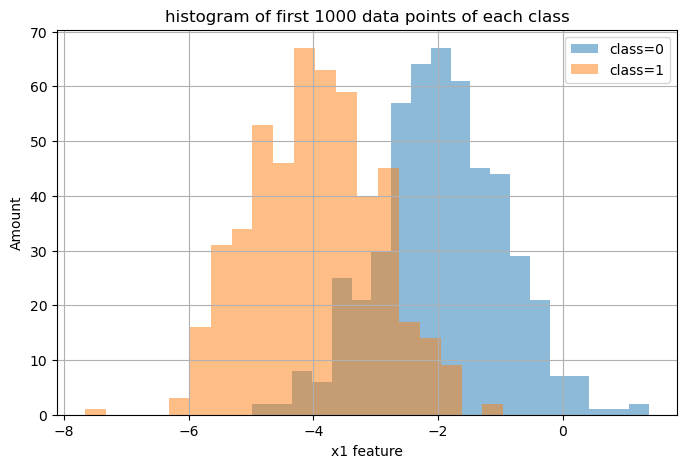

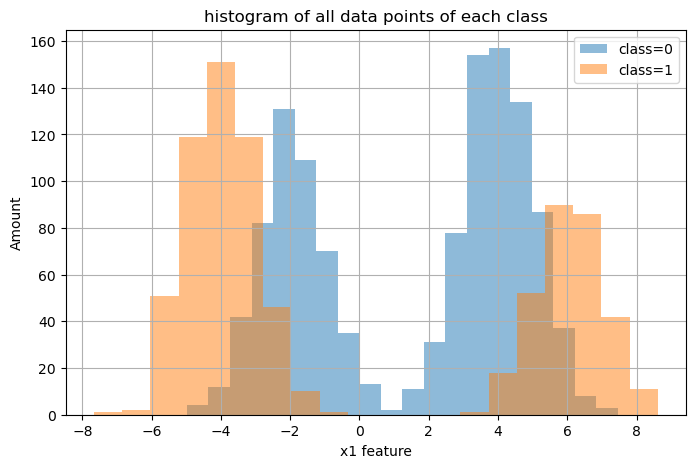

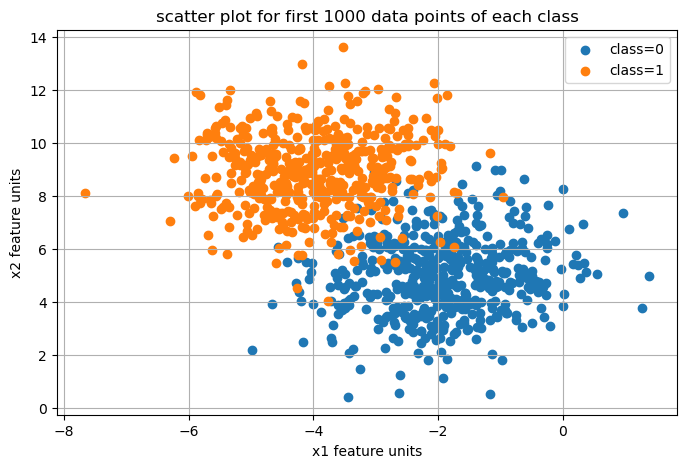

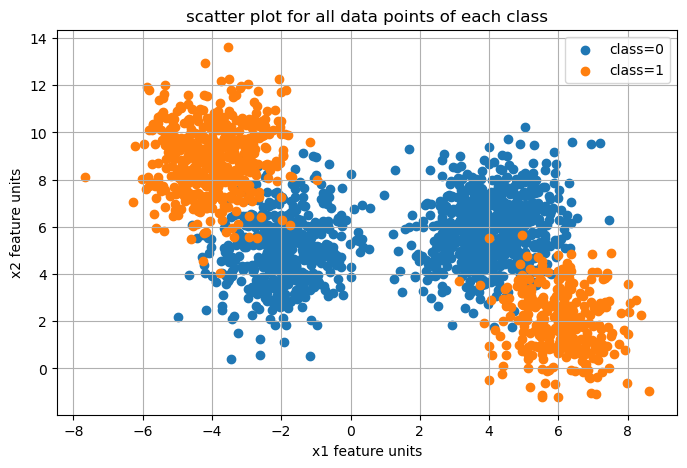

In [10]:
visualize_data(X_training, y_training)

## Logistic Regression (15 points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed
Your model should also store a list of the costs that you've calculated in each iteration

Open `hw4.py` and implement the `LogisticRegressionGD` class.

Note the following:
1. The `fit` method should train the model given the training data.
1. The `predict` method should provide predictions for given instances.
1. You can add as many auxiliary functions as you need. Only the above two functions will be tested.

In [11]:
# from hw4 import LogisticRegressionGD

In [12]:
# test lor class on all the data
lor = LogisticRegressionGD()
lor.fit(X_training, y_training)

predictions_x_train = lor.predict(X_training)
predictions_x_test = lor.predict(X_test)

## Cross Validation (10 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Open `hw4.py` and implement the function `cross_validation`.

Note the following:
1. This function should not change the original data.
1. You should shuffle the data before splitting in order to get correct results.
1. You should return the average accuracy for each fold in order to compare models with different hyper-parameters.

Shuffle the training set before you split the data to the folds.

In [13]:
# from hw4 import cross_validation

In [14]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
folds = 5

random_state = 1
acc_dict = {}
for eta in etas:
    for eps in epss:
        lor = LogisticRegressionGD(eta=eta, eps=eps, random_state=random_state)
        acc = cross_validation(X_training, y_training, folds, lor, random_state=random_state)
        acc_dict[(eta, eps)] = acc
        print(f"Accuracy with eta={eta}, eps={eps}:  {acc:.6f}")

best_params = max(acc_dict, key=acc_dict.get)
best_eta = best_params[0]
best_eps = best_params[1]

Accuracy with eta=0.05, eps=0.01:  0.493500
Accuracy with eta=0.05, eps=0.001:  0.554000
Accuracy with eta=0.05, eps=0.0001:  0.570500
Accuracy with eta=0.05, eps=1e-05:  0.651500
Accuracy with eta=0.05, eps=1e-06:  0.793000
Accuracy with eta=0.005, eps=0.01:  0.395000
Accuracy with eta=0.005, eps=0.001:  0.530500
Accuracy with eta=0.005, eps=0.0001:  0.534500
Accuracy with eta=0.005, eps=1e-05:  0.566500
Accuracy with eta=0.005, eps=1e-06:  0.651000
Accuracy with eta=0.0005, eps=0.01:  0.377500
Accuracy with eta=0.0005, eps=0.001:  0.394000
Accuracy with eta=0.0005, eps=0.0001:  0.546500
Accuracy with eta=0.0005, eps=1e-05:  0.532500
Accuracy with eta=0.0005, eps=1e-06:  0.565000
Accuracy with eta=5e-05, eps=0.01:  0.377500
Accuracy with eta=5e-05, eps=0.001:  0.377500
Accuracy with eta=5e-05, eps=0.0001:  0.394000
Accuracy with eta=5e-05, eps=1e-05:  0.642000
Accuracy with eta=5e-05, eps=1e-06:  0.642000
Accuracy with eta=5e-06, eps=0.01:  0.377500
Accuracy with eta=5e-06, eps=0.001:

In [15]:
print(f"Best learning rate (eta): {best_eta}")
print(f"Best epsilon: {best_eps}")

best_acc = acc_dict[best_params]
print(f"Accuracy with the best parameters: {best_acc:.4f}")

Best learning rate (eta): 0.05
Best epsilon: 1e-06
Accuracy with the best parameters: 0.7930


### Normal distribution pdf (5 points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Open `hw4.py` and implement the function `norm_pdf`.

It might be a good idea to test your implementation in the next cell before you continue.

In [16]:
# from hw4 import norm_pdf

## your tests here ##

## Expectation Maximization (15 points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

Open `hw4.py` and implement the class `EM`.

In [17]:
# from hw4 import EM

In [18]:
em_obj = EM(k=2)
em_obj.fit(X_training[:, 0].reshape(-1, 1))

print(f"mus = {em_obj.get_dist_params()[1]}")
print(f"sigmas = {em_obj.get_dist_params()[2]}")
print(f"weights = {em_obj.get_dist_params()[0]}")

mus = [[-2.96294149]
 [ 4.64054304]]
sigmas = [[1.42164449]
 [1.37552318]]
weights = [[0.4992362]
 [0.5007638]]


### GMM (5 points)

Open `hw4.py` and implement the function `gmm_pdf`.

It might be a good idea to test your implementation in the next cell before you continue.

In [19]:
# from hw4 import gmm_pdf

## your tests here ##

## Naive Bayes (15 points)

Implement the Naive Bayes algorithm.

Calculate the likelihood using the EM algorithm you implemented above and find the distribution parameters. With these parameters you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Note the following:
1. The `fit` method should train the model given the training data.
1. The `predict` method should provide predictions for given instances.
1. You can add as many auxiliary functions as you need. Only the above two functions will be tested.

In [20]:
# from hw4 import NaiveBayesGaussian

In [21]:
# test Naive Bayes
naive_byes = NaiveBayesGaussian(k=2)
naive_byes.fit(X_training, y_training)
predictions_x_train = naive_byes.predict(X_training)
predictions_x_test = naive_byes.predict(X_test)
train_acc = np.count_nonzero(predictions_x_train == y_training.reshape(-1, 1)) / len(y_training)
test_acc = np.count_nonzero(predictions_x_test == y_test.reshape(-1, 1)) / len(y_test)
print(f"Naive byes training set accuracy: {train_acc:.4f}")
print(f"Naive byes test set accuracy: {test_acc:.4f}")

Naive byes training set accuracy: 1043.4000
Naive byes test set accuracy: 522.0000


## Model evaluation (15 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

In [22]:
# from hw4 import model_evaluation

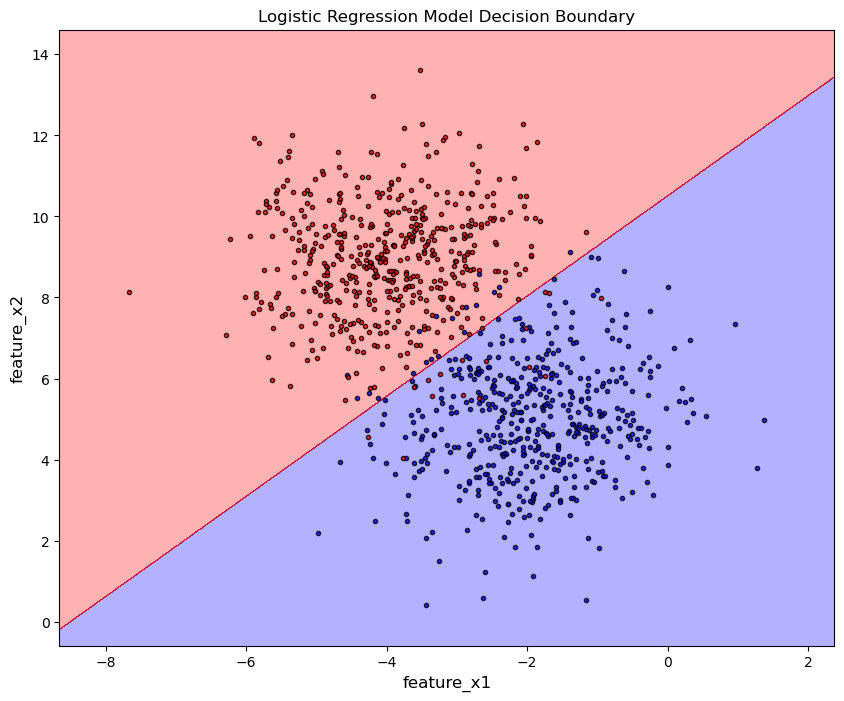

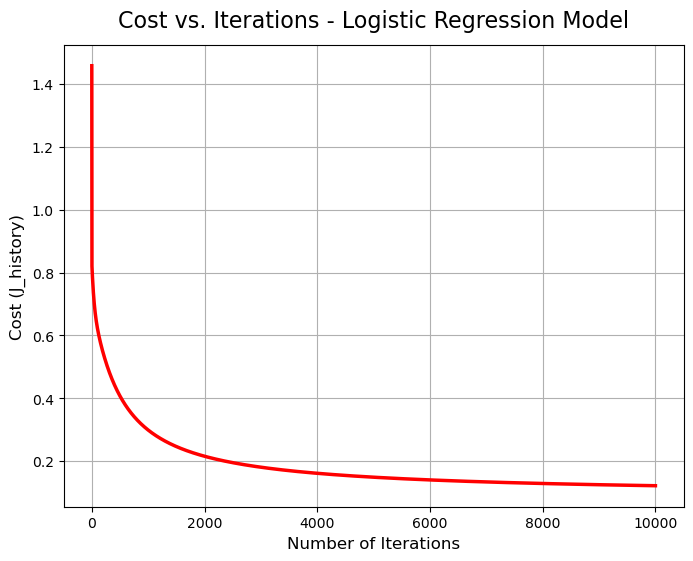

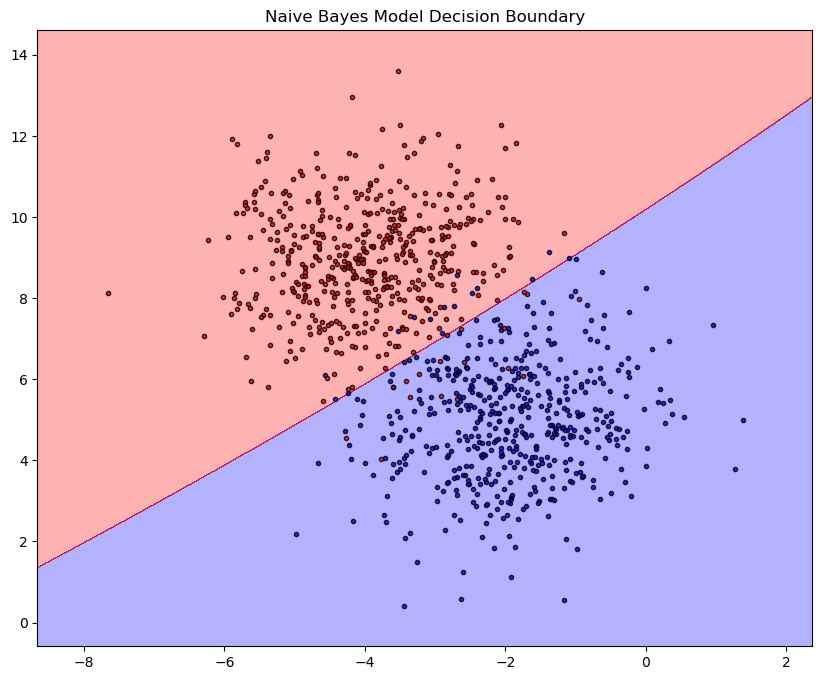

{'lor_train_acc': 0.965, 'lor_test_acc': 0.938, 'bayes_train_acc': 0.966}

In [23]:
# Train - 1000, Test - 500
X_training_1000 = X_training[:1000, :]
y_training_1000 = y_training[:1000]

X_test_500 = X_test[:500, :]
y_test_500 = y_test[:500]

model_evaluation(X_training_1000, y_training_1000, X_test_500, y_test_500, 1, best_eta, best_eps)

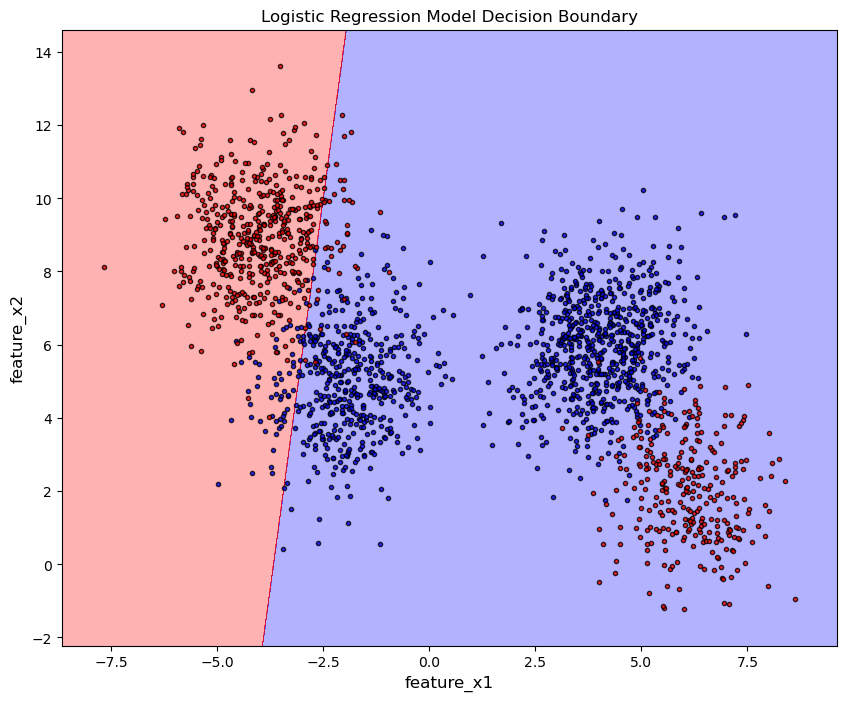

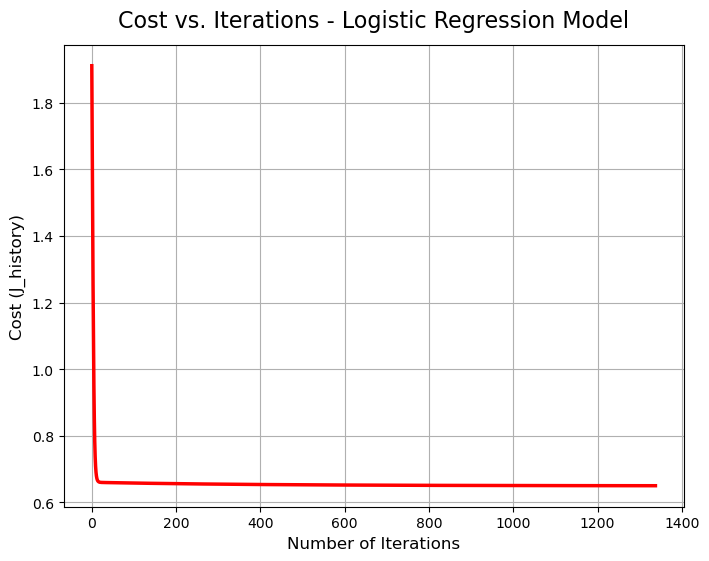

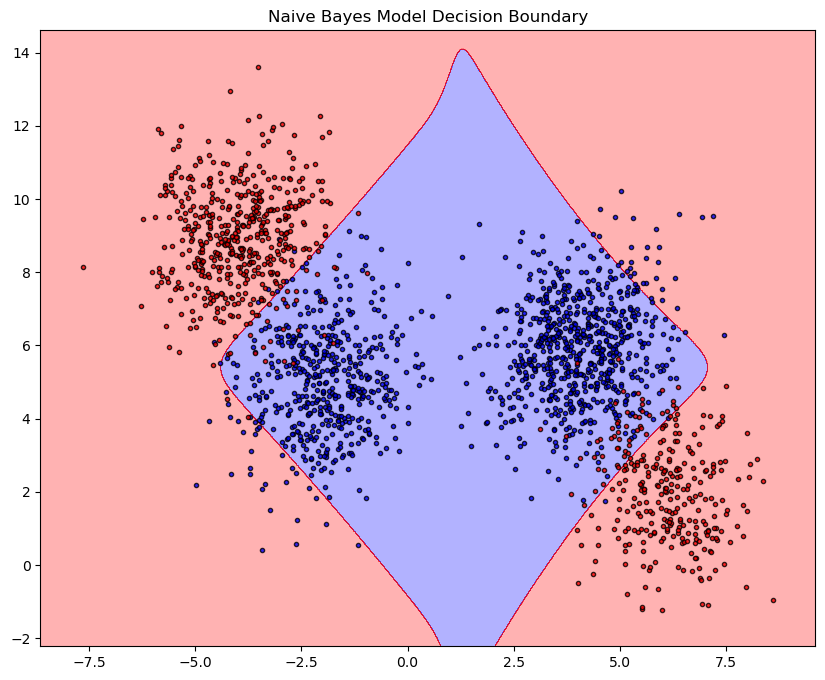

{'lor_train_acc': 0.796, 'lor_test_acc': 0.792, 'bayes_train_acc': 0.9215}

In [24]:
# Full Data
model_evaluation(X_training, y_training, X_test, y_test, 2, best_eta, best_eps)

## Open question (15 points)
1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset (`dataset_a`), in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) such that **Naive Bayes will work better on it when compared to Logisitc Regression**.
   2. Generate another dataset (`dataset_b`), in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) such that **Logistic Regression will work better on it when compared to Naive Bayes**.
   
2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

In [25]:
# from hw4 import generate_datasets

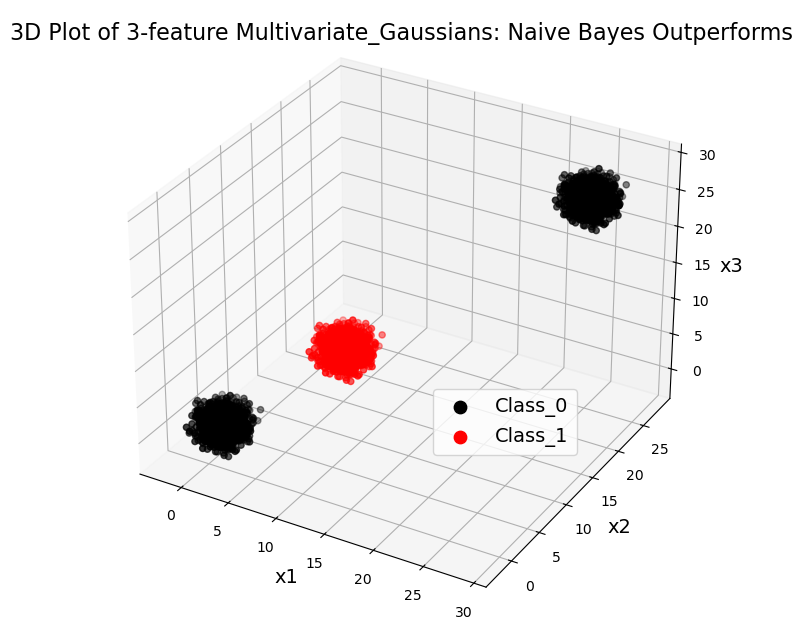

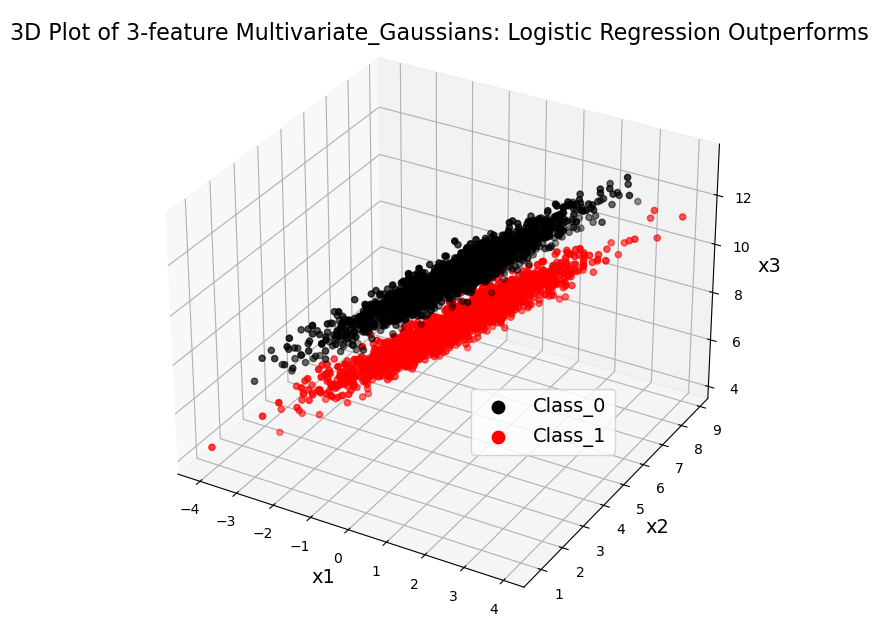

{'dataset_a_features': array([[ 1.49671415,  0.8617357 ,  1.64768854],
        [ 2.52302986,  0.76584663,  0.76586304],
        [ 2.57921282,  1.76743473,  0.53052561],
        ...,
        [25.30638948, 24.00169322, 25.51879302],
        [25.86352824, 25.17146932, 26.1526481 ],
        [23.78259621, 25.46795042, 23.82971929]]),
 'dataset_a_labels': array([0., 0., 0., ..., 0., 0., 0.]),
 'dataset_b_features': array([[ 0.76720143,  6.02802392, 10.92969985],
        [ 0.13406612,  5.35515438,  9.87786626],
        [ 0.30678194,  5.07393436, 10.25163518],
        ...,
        [-0.09102664,  5.20137441,  7.15501371],
        [-0.46077542,  5.06091029,  7.18408168],
        [ 0.39647513,  5.08879221,  7.84263049]]),
 'dataset_b_labels': array([0., 0., 0., ..., 1., 1., 1.])}

In [26]:
## your tests here ##
generate_datasets()